<h3>CNN-SVM</h3>
<p>Extract features from CNN layer, to be passed into SVM for classification</p>

Load the masked original and inpainted images from the mask_image folder. Before you continue for this section please make sure you have ran preprocessing_and_eda.ipynb

In [2]:
import os
import numpy as np
from PIL import Image
import cv2

def load_image_paths_from_folder(folder, label):
    image_paths = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith((".png", ".jpg", ".jpeg")):
            img_path = os.path.join(folder, filename)
            image_paths.append(img_path)
            labels.append(label)
    return image_paths, labels

# Load real image paths (label = 1)
# real_folder = "extracted_images/original"
real_folder = "mask_images/original"
real_image_paths, real_labels = load_image_paths_from_folder(real_folder, label=1)

# Load fake image paths (label = 0)
# fake_folder = "extracted_images/inpainting"
fake_folder = "mask_images/inpainting"
fake_image_paths, fake_labels = load_image_paths_from_folder(fake_folder, label=0)

# Combine real and fake image paths and labels
image_paths = real_image_paths + fake_image_paths
labels = real_labels + fake_labels

# Convert labels to NumPy array
labels = np.array(labels)

# Check number of images loaded
print(f"Number of real images: {len(real_image_paths)}")
print(f"Number of fake images: {len(fake_image_paths)}")
print(f"Total number of images: {len(image_paths)}")

# Function to load and preprocess images (to be used when training the model)
def load_and_preprocess_image(image_path, target_size=(256, 256), preserve_texture=True):
    img = Image.open(image_path)
    img = img.convert('RGB')  # Convert to RGB
    if preserve_texture:
        # Convert to numpy array for OpenCV processing
        img_array = np.array(img)
        
        # Use Lanczos resampling which better preserves high-frequency details
        img_array = cv2.resize(
            img_array, 
            target_size, 
            interpolation=cv2.INTER_LANCZOS4
        )
    else:
        img = img.resize(target_size)  # Resize the image
        img_array = np.array(img)

    img_array = img_array.astype(np.float32)
    img_array /= 255.0  # Normalize to [0, 1]
    return img_array

Number of real images: 13313
Number of fake images: 13313
Total number of images: 26626


In [2]:
from sklearn.model_selection import train_test_split
# Perform train-test split
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

# Print the shapes of the resulting datasets
print("\nAfter train-test split:")
print(f"Train set size: {len(train_paths)}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Test set size: {len(test_paths)}")
print(f"Test labels shape: {test_labels.shape}")

# Print the distribution of labels in train and test sets
print(f"\nTrain set - Real: {np.sum(train_labels == 1)}, Fake: {np.sum(train_labels == 0)}")
print(f"Test set - Real: {np.sum(test_labels == 1)}, Fake: {np.sum(test_labels == 0)}")


After train-test split:
Train set size: 21300
Train labels shape: (21300,)
Test set size: 5326
Test labels shape: (5326,)

Train set - Real: 10650, Fake: 10650
Test set - Real: 2663, Fake: 2663


In [3]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

<b>CNN Model Definition</b>


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2

def improved_deepfake_detection_model(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)
    
    # Convolutional layers
    x = Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Additional convolutional layer
    x = Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)
    
    # Dense layers
    x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    
    x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    
    # Final layer
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create the model
model = improved_deepfake_detection_model()

# Print model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496 

In [5]:
# view keys for best weights
import h5py

with h5py.File('model_weights_cnn/best_weights.h5', 'r') as h5file:
    print("Keys in the file:")
    for key in h5file.keys():
        print(key)

Keys in the file:
activation
activation_1
activation_2
activation_3
batch_normalization
batch_normalization_1
batch_normalization_2
batch_normalization_3
batch_normalization_4
batch_normalization_5
conv2d
conv2d_1
conv2d_2
conv2d_3
dense
dense_1
dense_2
dropout
dropout_1
global_average_pooling2d
input_1
max_pooling2d
max_pooling2d_1
max_pooling2d_2
max_pooling2d_3
top_level_model_weights


<b>Loading of model weights</b>

In [6]:
# loading weights

with h5py.File('model_weights_cnn/best_weights.h5', 'r') as h5file:
    weights_group = h5file['top_level_model_weights']
    
    # Iterate over the layers in the model and set weights
    for layer in model.layers:
        if layer.name in weights_group:
            layer_weights = [weights_group[layer.name][w] for w in weights_group[layer.name]]
            layer.set_weights(layer_weights)

print("Weights loaded successfully!")

Weights loaded successfully!


<b>Extracting features from global_average_pooling2d layer</b>

<p>Replace model.get_layer('global_average_pooling2d').output with the layer you want to extract from</p>

In [8]:
import numpy as np
from tensorflow.keras.models import Model
from concurrent.futures import ThreadPoolExecutor, as_completed
import tqdm
import multiprocessing
from tensorflow.data import Dataset

def process_batch(args):
    batch_paths, feature_extractor = args
    batch_arrays = np.array([load_and_preprocess_image(path, target_size=(256, 256)) 
                            for path in batch_paths])
    features = feature_extractor.predict(batch_arrays, verbose=0)
    return features

def extract_features_parallel(image_paths, model, batch_size=32):
    # Create feature extractor with mixed precision
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy('mixed_float16')
    
    feature_extractor = Model(
        inputs=model.input, 
        outputs=model.get_layer('global_average_pooling2d').output
    )

    # Split into batches
    batches = [image_paths[i:i + batch_size] for i in range(0, len(image_paths), batch_size)]
    args = [(batch, feature_extractor) for batch in batches]

    # Use process pool for CPU operations
    num_workers = multiprocessing.cpu_count()
    features = []
    
    # Process batches in parallel
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(process_batch, arg) for arg in args]
        
        for future in tqdm.tqdm(as_completed(futures), total=len(futures)):
            batch_features = future.result()
            features.extend(batch_features)

    features = np.array(features)
    np.save('extracted_features.npy', features)
    return features

# Create TF dataset for efficient loading
def create_dataset(image_paths, batch_size=32):
    dataset = Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(
        lambda x: tf.py_function(load_and_preprocess_image, [x], tf.float32),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

features = extract_features_parallel(image_paths, model)


The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


100%|██████████| 833/833 [02:46<00:00,  4.99it/s]


In [43]:
# can try PCA afterwards, run above without PCA first // can adjust variance %

import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score

features = np.load('extracted_features.npy') 
train_paths, test_paths, train_labels, test_labels = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)

# Step 2: Standardize the features
scaler = StandardScaler()
train_paths = scaler.fit_transform(train_paths)
test_paths = scaler.transform(test_paths)

# # Step 3: Apply PCA
# pca = PCA(n_components=0.85)  # Retain 85% of the variance
# train_paths = pca.fit_transform(train_paths)
# test_paths = pca.transform(test_paths)

In [11]:
from sklearn.svm import SVC

model_map = {"svm_linear": SVC(kernel = "linear"),
             "svm_rbf": SVC(kernel = "rbf"),
            "svm_poly": SVC(kernel = "poly")}

parameters_map = { 
    "C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],  # Further expanded range
    "gamma": [0.0001, 0.001, 0.01, 0.1, 1, 10],  # Further expanded range
    "degree": [2, 3, 4, 5, 6]  # Added more degrees for poly kernel
}


def fine_tune(model: str, param_grid: dict, folds:int = 3):
    return HalvingGridSearchCV(model_map[model], param_grid, n_jobs = -1, refit = True, cv = folds, verbose = 3, factor = 3, resource = "n_samples")

<b>CNN + SVM Model with Linear Kernel</b>

In [12]:
# linear

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV

linear_svm = fine_tune("svm_linear", parameters_map)
linear_svm.fit(train_paths, train_labels)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 262
max_resources_: 21300
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 210
n_resources: 262
Fitting 3 folds for each of 210 candidates, totalling 630 fits
----------
iter: 1
n_candidates: 70
n_resources: 786
Fitting 3 folds for each of 70 candidates, totalling 210 fits
----------
iter: 2
n_candidates: 24
n_resources: 2358
Fitting 3 folds for each of 24 candidates, totalling 72 fits
----------
iter: 3
n_candidates: 8
n_resources: 7074
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 4
n_candidates: 3
n_resources: 21222
Fitting 3 folds for each of 3 candidates, totalling 9 fits


HalvingGridSearchCV(cv=3, estimator=SVC(kernel='linear'), n_jobs=-1,
                    param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                                'degree': [2, 3, 4, 5, 6],
                                'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
                    verbose=3)

In [13]:
print(f"Grid search linear SVM best parameters: {linear_svm.best_params_}")
print(f"Cross validated score of the best linear SVM model: {linear_svm.best_score_}")

Grid search linear SVM best parameters: {'C': 0.1, 'degree': 2, 'gamma': 10}
Cross validated score of the best linear SVM model: 0.8083592498350768


In [14]:
y_pred = linear_svm.predict(test_paths)

In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

def prediction_score(test_labels, y_pred):
    # Calculate accuracy
    accuracy = accuracy_score(test_labels, y_pred)  
    print(f"Accuracy: {accuracy * 100:.2f}%")

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(test_labels, y_pred)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Calculate precision, recall, and F1 score
    precision = precision_score(test_labels, y_pred)
    recall = recall_score(test_labels, y_pred)
    f1 = f1_score(test_labels, y_pred)

    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

prediction_score(test_labels, y_pred)

Accuracy: 81.45%
Confusion Matrix:
[[2185  478]
 [ 510 2153]]
Precision: 0.82
Recall: 0.81
F1 Score: 0.81


<b>CNN + SVM Model with Polynomial Kernel</b>

In [16]:
# polynomial

poly_svm = fine_tune("svm_poly", parameters_map)
poly_svm.fit(train_paths, train_labels)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 262
max_resources_: 21300
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 210
n_resources: 262
Fitting 3 folds for each of 210 candidates, totalling 630 fits
----------
iter: 1
n_candidates: 70
n_resources: 786
Fitting 3 folds for each of 70 candidates, totalling 210 fits
----------
iter: 2
n_candidates: 24
n_resources: 2358
Fitting 3 folds for each of 24 candidates, totalling 72 fits
----------
iter: 3
n_candidates: 8
n_resources: 7074
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 4
n_candidates: 3
n_resources: 21222
Fitting 3 folds for each of 3 candidates, totalling 9 fits


HalvingGridSearchCV(cv=3, estimator=SVC(kernel='poly'), n_jobs=-1,
                    param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                                'degree': [2, 3, 4, 5, 6],
                                'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
                    verbose=3)

In [17]:
print(f"Grid search poly SVM best parameters: {poly_svm.best_params_}")
print(f"Cross validated score of the best poly SVM model: {poly_svm.best_score_}")

Grid search poly SVM best parameters: {'C': 10, 'degree': 3, 'gamma': 0.01}
Cross validated score of the best poly SVM model: 0.8112807463952502


In [18]:
y_pred_poly = poly_svm.predict(test_paths)

In [23]:
prediction_score(test_labels, y_pred_poly)

Accuracy: 81.49%
Confusion Matrix:
[[2256  407]
 [ 579 2084]]
Precision: 0.84
Recall: 0.78
F1 Score: 0.81


<b>CNN + SVM Model with RBF Kernel</b>

In [24]:
# rbf

rbf_svm = fine_tune("svm_rbf", parameters_map)
rbf_svm.fit(train_paths, train_labels)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 262
max_resources_: 21300
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 210
n_resources: 262
Fitting 3 folds for each of 210 candidates, totalling 630 fits
----------
iter: 1
n_candidates: 70
n_resources: 786
Fitting 3 folds for each of 70 candidates, totalling 210 fits


c:\Users\cheng\anaconda3\envs\CNNtrain\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


----------
iter: 2
n_candidates: 24
n_resources: 2358
Fitting 3 folds for each of 24 candidates, totalling 72 fits
----------
iter: 3
n_candidates: 8
n_resources: 7074
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 4
n_candidates: 3
n_resources: 21222
Fitting 3 folds for each of 3 candidates, totalling 9 fits


HalvingGridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
                    param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                                'degree': [2, 3, 4, 5, 6],
                                'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
                    verbose=3)

In [25]:
# Check the best parameters
print("Best parameters found:", rbf_svm.best_params_)

# Check the kernel of the best estimator
print("Kernel used:", rbf_svm.best_estimator_.kernel)

Best parameters found: {'C': 100, 'degree': 5, 'gamma': 0.0001}
Kernel used: rbf


In [26]:
y_pred_rbf = rbf_svm.predict(test_paths)

In [27]:
prediction_score(test_labels, y_pred_rbf)

Accuracy: 82.31%
Confusion Matrix:
[[2234  429]
 [ 513 2150]]
Precision: 0.83
Recall: 0.81
F1 Score: 0.82


<b>Ensemble Models</b>

In [ ]:
# testing out ensemble model (catboost + rbf) // 69.79% compared to just rbf of 70.34%

from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

# Define the parameter grid for SVC
svc_parameters_map = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'degree': [2, 3, 4, 5],
    'probability': [True]  
}

rbf_svm = SVC(kernel='rbf')

rbf_svm = HalvingGridSearchCV(
    estimator=rbf_svm,
    param_grid=svc_parameters_map,
    n_jobs=-1,
    refit=True,
    cv=3,
    verbose=3,
    factor=3,
    resource='n_samples'
)

rbf_svm.fit(train_paths, train_labels)

catboost_parameters_map = {
    'iterations': [100, 200],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1],
    'l2_leaf_reg': [1, 3, 5]
}

cat_clf = CatBoostClassifier(verbose=0, random_state=42)

catboost_search = HalvingGridSearchCV(
    estimator=cat_clf,
    param_grid=catboost_parameters_map,
    n_jobs=-1,
    refit=True,
    cv=3,
    verbose=3,
    factor=3,
    resource='n_samples'
)

catboost_search.fit(train_paths, train_labels)

# Create the ensemble model (Voting Classifier)
voting_clf = VotingClassifier(
    estimators=[
        ('cat', catboost_search.best_estimator_),
        ('rbf', rbf_svm.best_estimator_)
    ],
    voting='soft'
)

# Train the ensemble model
voting_clf.fit(train_paths, train_labels)

# Make predictions
y_pred = voting_clf.predict(test_paths)

# Evaluate the ensemble model
accuracy = accuracy_score(test_labels, y_pred)
print(f"Ensemble Model Accuracy: {accuracy}")

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 100
max_resources_: 8100
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 112
n_resources: 100
Fitting 3 folds for each of 112 candidates, totalling 336 fits
----------
iter: 1
n_candidates: 38
n_resources: 300
Fitting 3 folds for each of 38 candidates, totalling 114 fits
----------
iter: 2
n_candidates: 13
n_resources: 900
Fitting 3 folds for each of 13 candidates, totalling 39 fits
----------
iter: 3
n_candidates: 5
n_resources: 2700
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 4
n_candidates: 2
n_resources: 8100
Fitting 3 folds for each of 2 candidates, totalling 6 fits
n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 300
max_resources_: 8100
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 36
n_resources: 300
Fitting 3 folds for each of 36 candidates, totalling 108 fits
----------
iter: 1
n

In [28]:
from sklearn import svm
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
# Best parameters found: {'C': 1000, 'degree': 4, 'gamma': 0.0001}
#     {'C': 1, 'degree': 3, 'gamma': 0.01}
#     {'C': 1, 'degree': 4, 'gamma': 0.0001}

svm_rbf = svm.SVC(kernel='rbf', C=100, degree=5, gamma=0.0001, probability=True)
svm_linear = svm.SVC(kernel='linear', C=0.1, degree=2, gamma=10, probability=True)
svm_poly = svm.SVC(kernel='poly', C=10, degree=3, gamma=0.01, probability=True)

# Create an ensemble using VotingClassifier
ensemble_model = VotingClassifier(estimators=[
    ('rbf', svm_rbf),
    ('linear', svm_linear),
    ('poly', svm_poly)],
    voting='soft'  # Use 'soft' for probability-based voting
)

# Train the ensemble model
ensemble_model.fit(train_paths, train_labels)


# Evaluate the ensemble model
accuracy = ensemble_model.score(test_paths, test_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 82.88%


In [29]:
y_pred_ensemble = ensemble_model.predict(test_paths)
prediction_score(test_labels, y_pred_ensemble)

Accuracy: 82.88%
Confusion Matrix:
[[2243  420]
 [ 492 2171]]
Precision: 0.84
Recall: 0.82
F1 Score: 0.83


In [ ]:
from sklearn import svm
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

svm_rbf = svm.SVC(kernel='rbf', C=1000, degree=4, gamma=0.0001, probability=True)
svm_linear = svm.SVC(kernel='linear', C=1.0, degree=4, gamma=0.001, probability=True)
svm_poly = svm.SVC(kernel='poly', C=1.0, degree=4, gamma=0.0001, probability=True)

param_grid = {
    'n_estimators': [50, 100, 200],  
    'learning_rate': [0.01, 0.1, 0.2],  
    'max_depth': [3, 4, 5],  
    'subsample': [0.6, 0.8, 1.0],  
    'colsample_bytree': [0.6, 0.8, 1.0],  
}

# Initialize XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring='accuracy', n_jobs=-1, cv=3, verbose=1)

grid_search.fit(train_paths, train_labels)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score:.2f}")

# Create a stacking classifier with the best XGBoost model
best_xgb_model = grid_search.best_estimator_

# create ensemble with rbf, linear, poly, xgb with Logistic Regression as final estimator
stacking_model = StackingClassifier(
    estimators=[
        ('svm_rbf', svm_rbf),
        ('svm_linear', svm_linear),
        ('svm_poly', svm_poly),
        ('xgb', best_xgb_model)],
    final_estimator=LogisticRegression()
)

# Train the ensemble model
stacking_model.fit(train_paths, train_labels)

# Evaluate the ensemble model
accuracy = stacking_model.score(test_paths, test_labels)
print(f"Stacking Model Accuracy: {accuracy * 100:.2f}%")

In [ ]:
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
base_models = [
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')),
    ('rf', RandomForestClassifier(random_state=42))
]

final_estimator = SVC(kernel='rbf', probability=True)

stacked_model = StackingClassifier(estimators=base_models, final_estimator=final_estimator)


param_grid = {
    'xgb__n_estimators': [50, 100, 200],             
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__max_depth': [3, 4, 5],                       
    'rf__n_estimators': [50, 100, 200],               
    'rf__max_depth': [None, 10, 20, 30],               
    'final_estimator__C': [0.1, 1, 10],               
    'final_estimator__gamma': [0.01, 0.1, 1]           
}

def fine_tune_stacking(param_grid, folds=3):
    return HalvingGridSearchCV(stacked_model, param_grid, n_jobs=-1, refit=True, cv=folds, verbose=3, factor=3)

tuned_stacked_model = fine_tune_stacking(param_grid)
tuned_stacked_model.fit(train_paths, train_labels)

print(f"Grid search linear SVM best parameters: {tuned_stacked_model.best_params_}")
print(f"Cross validated score of the best linear SVM model: {tuned_stacked_model.best_score_}")

y_pred_rbf = tuned_stacked_model.predict(test_paths)

accuracy = accuracy_score(test_labels, y_pred_rbf)  
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred_rbf)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate precision, recall, and F1 score
precision = precision_score(test_labels, y_pred_rbf)
recall = recall_score(test_labels, y_pred_rbf)
f1 = f1_score(test_labels, y_pred_rbf)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

In [36]:
import matplotlib.pyplot as plt

def plot_mask_type_results(results):
    """
    Create visualizations for mask-wise performance with sorted data
    """
    # Convert results to sorted lists
    # Sort by accuracy for first plot
    sorted_by_accuracy = sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True)
    mask_types_acc = [item[0] for item in sorted_by_accuracy]
    accuracies = [results[mask]['accuracy'] for mask in mask_types_acc]
    auc_rocs = [results[mask]['auc_roc'] for mask in mask_types_acc]
    
    # Sort by number of samples for second plot
    sorted_by_samples = sorted(results.items(), key=lambda x: x[1]['num_samples'], reverse=True)
    mask_types_samples = [item[0] for item in sorted_by_samples]
    sample_counts = [results[mask]['num_samples'] for mask in mask_types_samples]
    
    # Plot accuracy and AUC-ROC comparison
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    x = np.arange(len(mask_types_acc))
    width = 0.35
    
    # Performance metrics plot (sorted by accuracy)
    bars1 = ax1.bar(x - width/2, accuracies, width, label='Accuracy', color='skyblue')
    bars2 = ax1.bar(x + width/2, auc_rocs, width, label='AUC-ROC', color='lightcoral')
    
    ax1.set_xlabel('Mask Type')
    ax1.set_ylabel('Score')
    ax1.set_title('Model Performance by Mask Type (Sorted by Accuracy)')
    ax1.set_xticks(x)
    ax1.set_xticklabels(mask_types_acc, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on the bars
    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom')
    
    add_value_labels(bars1)
    add_value_labels(bars2)
    
    # Sample distribution plot (sorted by sample count)
    ax2.bar(mask_types_samples, sample_counts, color='lightgreen')
    ax2.set_xlabel('Mask Type')
    ax2.set_ylabel('Number of Samples')
    ax2.set_title('Sample Distribution Across Mask Types (Sorted by Sample Count)')
    ax2.set_xticklabels(mask_types_samples, rotation=45, ha='right')
    
    # Add value labels on the bars
    for i, v in enumerate(sample_counts):
        ax2.text(i, v, str(v), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Plot confusion matrices for each mask type (sorted by accuracy)
    num_masks = len(mask_types_acc)
    fig_rows = (num_masks + 2) // 3  # Calculate number of rows needed
    plt.figure(figsize=(15, 5 * fig_rows))
    
    for idx, mask_type in enumerate(mask_types_acc, 1):
        cm = results[mask_type]['confusion_matrix']
        plt.subplot(fig_rows, 3, idx)
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(f'{mask_type}\n(n={results[mask_type]["num_samples"]})')
        
        plt.xticks([0, 1], ['Fake', 'Real'], rotation=45)
        plt.yticks([0, 1], ['Fake', 'Real'])
        
        # Add text annotations
        thresh = cm.max() / 2
        for i, j in np.ndindex(cm.shape):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.show()

Overall Accuracy: 0.829

Mask type: diagonal_bottom_left
Number of samples: 929
Sample paths:
  diagonal_bottom_left_dir2_inpainting_82.png
  diagonal_bottom_left_dir1_inpainting_2266.png
  diagonal_bottom_left_dir2_inpainting_1346.png
Accuracy: 0.774
AUC-ROC: 0.849

Mask type: diagonal_bottom_right
Number of samples: 938
Sample paths:
  diagonal_bottom_right_dir2_inpainting_302.png
  diagonal_bottom_right_dir1_original_12762.png
  diagonal_bottom_right_dir1_original_11002.png
Accuracy: 0.784
AUC-ROC: 0.869

Mask type: diagonal_top_right
Number of samples: 866
Sample paths:
  diagonal_top_right_dir2_inpainting_184.png
  diagonal_top_right_dir1_original_12197.png
  diagonal_top_right_dir2_inpainting_1431.png
Accuracy: 0.851
AUC-ROC: 0.934

Mask type: random
Number of samples: 1083
Sample paths:
  random_dir2_original_192.png
  random_dir1_original_13378.png
  random_dir1_inpainting_10269.png
Accuracy: 0.896
AUC-ROC: 0.955

Mask type: diagonal_top_left
Number of samples: 920
Sample paths

C:\Users\cheng\AppData\Local\Temp\ipykernel_41492\1308949375.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(mask_types_samples, rotation=45, ha='right')


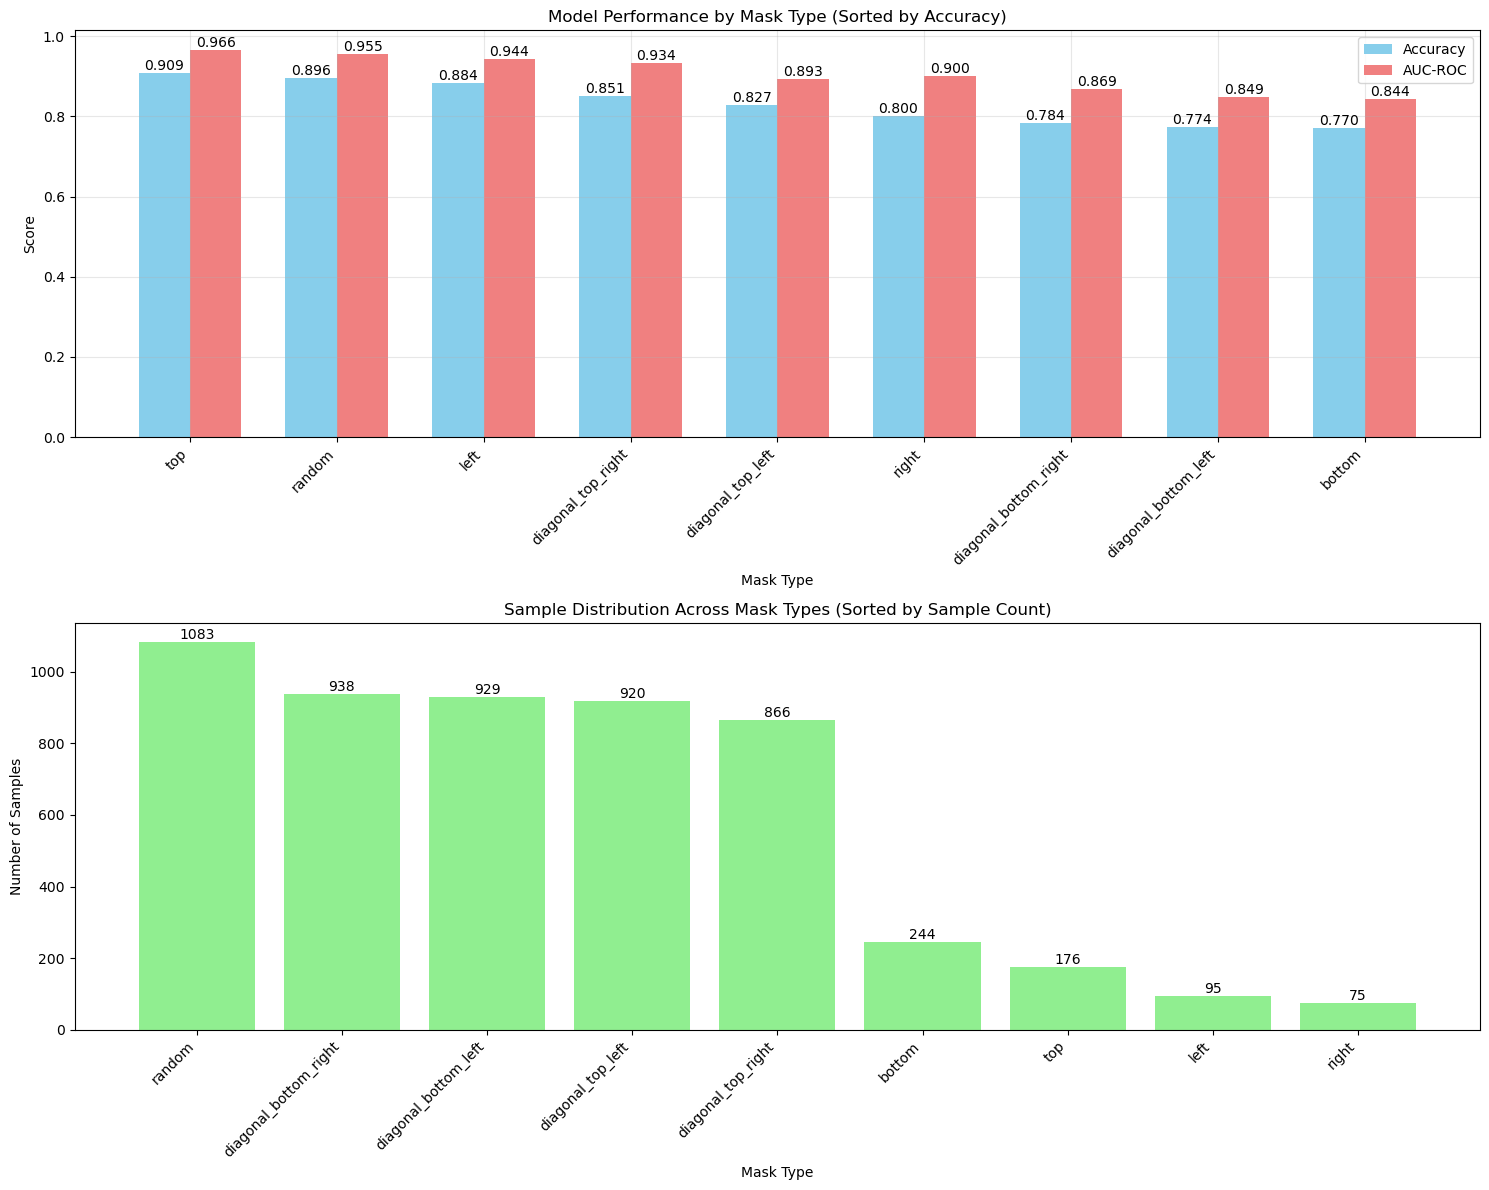

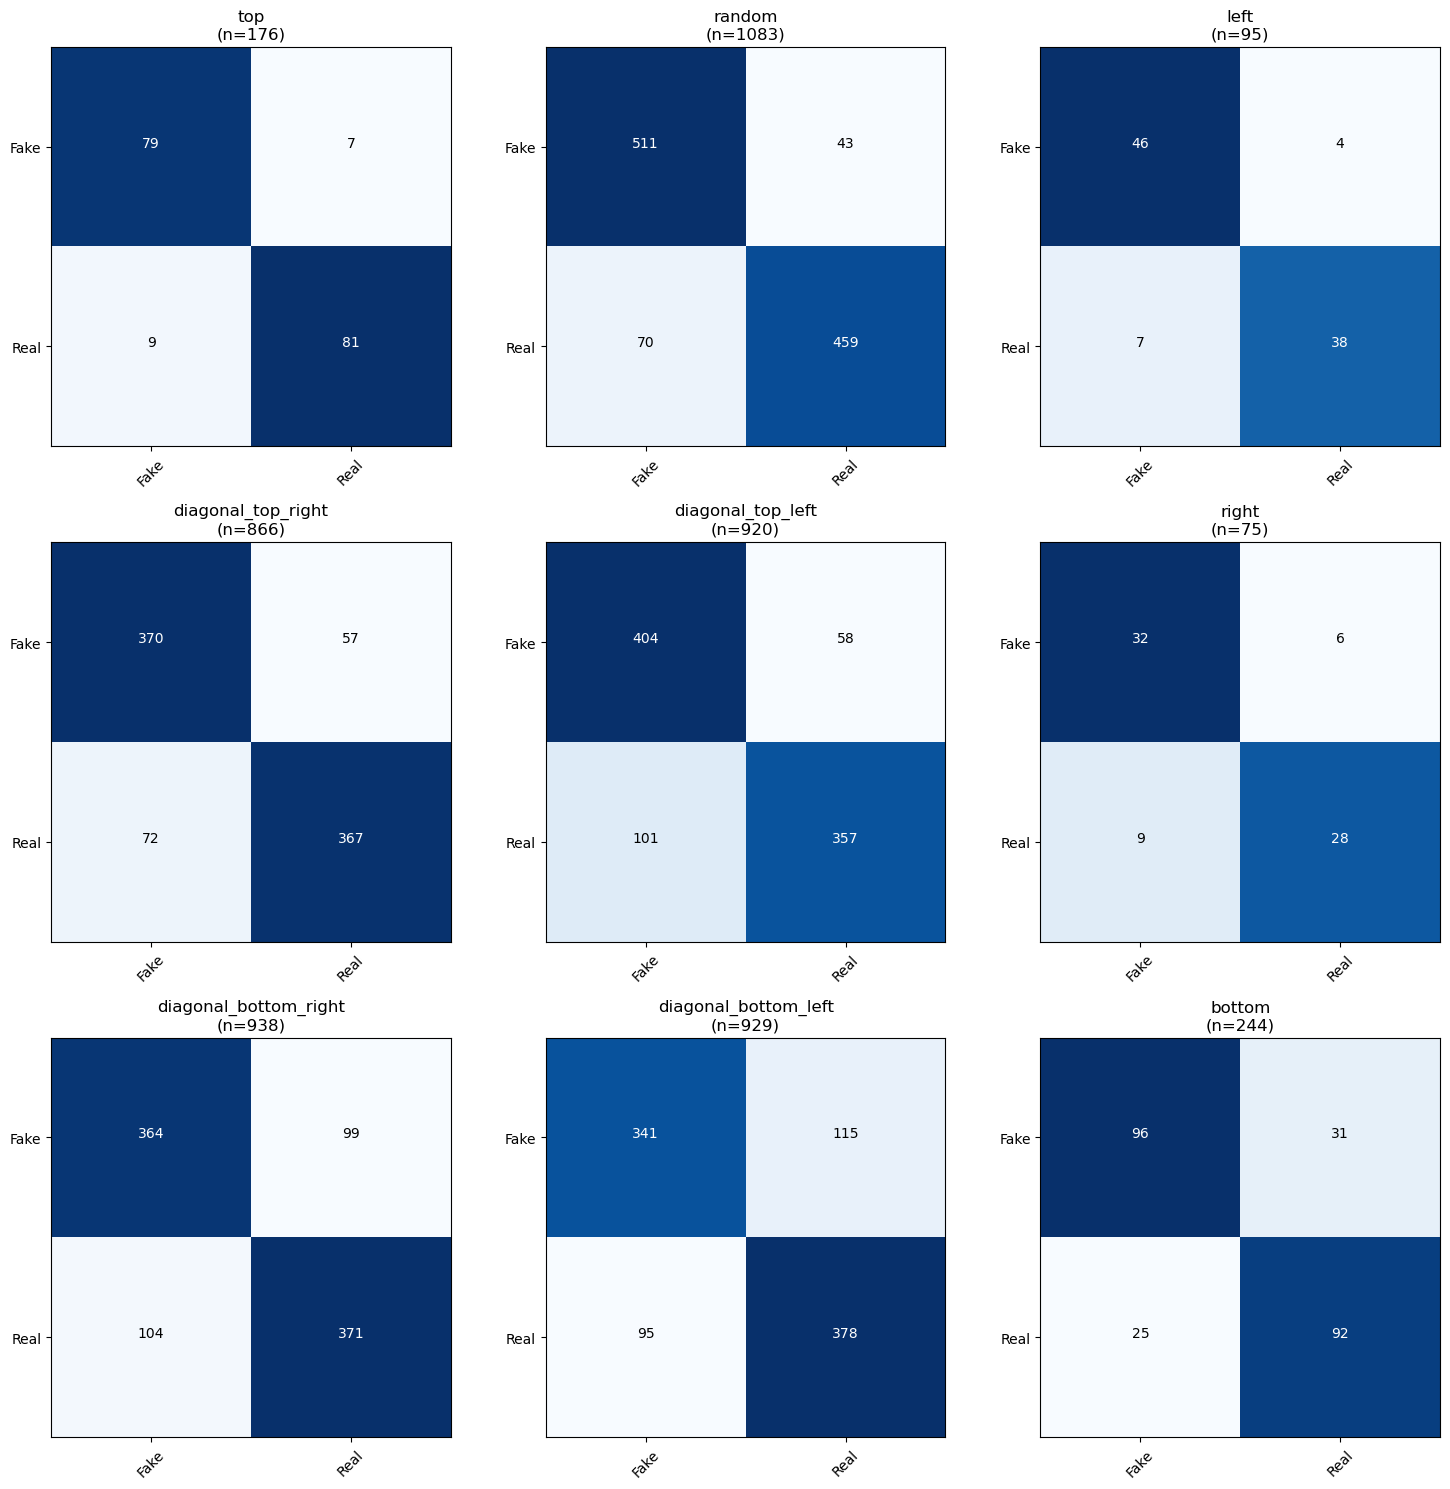

In [45]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
def analyze_ensemble_by_mask_from_splits(ensemble_model, paths, labels, features):
    def extract_mask_type(filename):
        diagonal_patterns = ['diagonal_top_left', 'diagonal_top_right', 
                           'diagonal_bottom_left', 'diagonal_bottom_right']
        basic_patterns = ['top', 'bottom', 'left', 'right', 'random']
        
        # Convert filename to string and get basename
        filename = os.path.basename(str(filename))
        
        for pattern in diagonal_patterns:
            if pattern in filename:
                return pattern
        for pattern in basic_patterns:
            if filename.startswith(pattern):
                return pattern
        return 'random'

    # First get overall prediction
    y_pred_all = ensemble_model.predict(features)
    print(f"Overall Accuracy: {accuracy_score(labels, y_pred_all):.3f}")

    # Group samples by mask type
    mask_groups = {}
    for path, label, feature in zip(paths, labels, features):
        mask_type = extract_mask_type(path)
        if mask_type not in mask_groups:
            mask_groups[mask_type] = {'features': [], 'labels': [], 'paths': []}
        mask_groups[mask_type]['features'].append(feature)
        mask_groups[mask_type]['labels'].append(label)
        mask_groups[mask_type]['paths'].append(path)

    results = {}
    for mask_type, data in mask_groups.items():
        mask_features = np.array(data['features'])
        mask_labels = np.array(data['labels'])
        
        # Print some debugging info
        print(f"\nMask type: {mask_type}")
        print(f"Number of samples: {len(mask_labels)}")
        print(f"Sample paths:")
        for p in data['paths'][:3]:  # Print first 3 paths
            print(f"  {os.path.basename(str(p))}")
        
        y_pred = ensemble_model.predict(mask_features)
        y_pred_proba = ensemble_model.predict_proba(mask_features)
        
        acc = accuracy_score(mask_labels, y_pred)
        auc = roc_auc_score(mask_labels, y_pred_proba[:, 1])
        
        print(f"Accuracy: {acc:.3f}")
        print(f"AUC-ROC: {auc:.3f}")
        
        results[mask_type] = {
            'accuracy': acc,
            'auc_roc': auc,
            'confusion_matrix': confusion_matrix(mask_labels, y_pred),
            'num_samples': len(mask_labels),
            'svm_performances': {
                name: {
                    'accuracy': accuracy_score(mask_labels, clf.predict(mask_features)),
                    'auc_roc': roc_auc_score(mask_labels, clf.predict_proba(mask_features)[:, 1])
                }
                for name, clf in ensemble_model.named_estimators_.items()
            }
        }
    
    return results

# Usage
# First split paths and labels
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

# Then split features using same train/test indices
features = np.load('extracted_features.npy')
train_features, test_features = train_test_split(
    features, test_size=0.2, random_state=42, stratify=labels
)

# Standardize features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

results = analyze_ensemble_by_mask_from_splits(ensemble_model, test_paths, test_labels, test_features)
plot_mask_type_results(results)

<b>Extracting features from the conv2d_10 layer</b>
- replace with the layer you want to extract from 
- run model.summary() to view layers

In [ ]:
from tensorflow.keras.models import Model

# Function to extract features using the CNN
def extract_features(image_paths, model):
    features = []
    for img_path in image_paths:
        img_array = load_and_preprocess_image(img_path, target_size=(256, 256))
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Extract features
        feature = model.predict(img_array)
        features.append(feature.flatten())  # Flatten if necessary
    return np.array(features)

# extract features, from conv2d_10 layer
# Replace with the layer you want to extract from
feature_extractor = Model(inputs=model.input, outputs=model.get_layer('conv2d_10').output)

# Extract features
features = extract_features(image_paths, feature_extractor)

In [ ]:
np.save('features_conv2d_10.npy', features)  # Saves as a .npy file
print("saved")

In [15]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

train_paths, test_paths, train_labels, test_labels = train_test_split(
    features_dense2, labels, test_size=0.2, random_state=42, stratify=labels
)

scaler = StandardScaler()

train_paths = scaler.fit_transform(train_paths)
test_paths = scaler.transform(test_paths)

In [ ]:
# can try PCA afterwards, run above without PCA first // can adjust variance %

# import numpy as np
# from sklearn import svm
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.metrics import classification_report, accuracy_score


# train_paths, test_paths, train_labels, test_labels = train_test_split(
#     features, labels, test_size=0.2, random_state=42, stratify=labels
# )

# # Step 2: Standardize the features
# scaler = StandardScaler()
# train_paths = scaler.fit_transform(train_paths)
# test_paths = scaler.transform(test_paths)

# # Step 3: Apply PCA
# pca = PCA(n_components=0.85)  # Retain 85% of the variance
# train_paths = pca.fit_transform(train_paths)
# test_paths = pca.transform(test_paths)


In [ ]:
# linear

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV

linear_svm = fine_tune("svm_linear", parameters_map)
linear_svm.fit(train_paths, train_labels)

In [ ]:
print(f"Grid search linear SVM best parameters: {linear_svm.best_params_}")
print(f"Cross validated score of the best linear SVM model: {linear_svm.best_score_}")

In [ ]:
y_pred = linear_svm.predict(test_paths)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred)  
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate precision, recall, and F1 score
precision = precision_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


In [ ]:
# polynomial

poly_svm = fine_tune("svm_poly", parameters_map)
poly_svm.fit(train_paths, train_labels)

In [ ]:
print(f"Grid search poly SVM best parameters: {poly_svm.best_params_}")
print(f"Cross validated score of the best poly SVM model: {poly_svm.best_score_}")

In [ ]:
y_pred_poly = poly_svm.predict(test_paths)

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred_poly)  
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred_poly)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate precision, recall, and F1 score
precision = precision_score(test_labels, y_pred_poly)
recall = recall_score(test_labels, y_pred_poly)
f1 = f1_score(test_labels, y_pred_poly)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


In [ ]:
# rbf

rbf_svm = fine_tune("svm_rbf", parameters_map)
rbf_svm.fit(train_paths, train_labels)

In [ ]:
# Check the best parameters
print("Best parameters found:", rbf_svm.best_params_)

# Check the kernel of the best estimator
print("Kernel used:", rbf_svm.best_estimator_.kernel)

In [ ]:
y_pred_rbf = rbf_svm.predict(test_paths)

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred_rbf)  
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred_rbf)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate precision, recall, and F1 score
precision = precision_score(test_labels, y_pred_rbf)
recall = recall_score(test_labels, y_pred_rbf)
f1 = f1_score(test_labels, y_pred_rbf)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


<b>Extracting features from the conv2d_9 layer</b>
- replace with the layer you want to extract from 
- run model.summary() to view layers

In [ ]:
from tensorflow.keras.models import Model

# Function to extract features using the CNN
def extract_features(image_paths, model):
    features = []
    for img_path in image_paths:
        img_array = load_and_preprocess_image(img_path, target_size=(256, 256))
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Extract features
        feature = model.predict(img_array)
        features.append(feature.flatten())  # Flatten if necessary
    return np.array(features)

# extract features, from conv2d_9 layer
# Replace with the layer you want to extract from
feature_extractor = Model(inputs=model.input, outputs=model.get_layer('conv2d_9').output)

# Extract features
features = extract_features(image_paths, feature_extractor)

In [ ]:
np.save('features_conv2d_9.npy', features)  # Saves as a .npy file
print("saved")

In [217]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

train_paths, test_paths, train_labels, test_labels = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)

scaler = StandardScaler()
train_paths = scaler.fit_transform(train_paths)
test_paths = scaler.transform(test_paths)

In [ ]:
# can try PCA afterwards, run above without PCA first // can adjust variance %

# import numpy as np
# from sklearn import svm
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.metrics import classification_report, accuracy_score


# train_paths, test_paths, train_labels, test_labels = train_test_split(
#     features, labels, test_size=0.2, random_state=42, stratify=labels
# )

# # Step 2: Standardize the features
# scaler = StandardScaler()
# train_paths = scaler.fit_transform(train_paths)
# test_paths = scaler.transform(test_paths)

# # Step 3: Apply PCA
# pca = PCA(n_components=0.85)  # Retain 85% of the variance
# train_paths = pca.fit_transform(train_paths)
# test_paths = pca.transform(test_paths)


In [ ]:
# linear

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV

linear_svm = fine_tune("svm_linear", parameters_map)
linear_svm.fit(train_paths, train_labels)

In [ ]:
print(f"Grid search linear SVM best parameters: {linear_svm.best_params_}")
print(f"Cross validated score of the best linear SVM model: {linear_svm.best_score_}")

In [ ]:
y_pred = linear_svm.predict(test_paths)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred)  
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate precision, recall, and F1 score
precision = precision_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
 


In [ ]:
# polynomial

poly_svm = fine_tune("svm_poly", parameters_map)
poly_svm.fit(train_paths, train_labels)


In [ ]:
print(f"Grid search poly SVM best parameters: {poly_svm.best_params_}")
print(f"Cross validated score of the best poly SVM model: {poly_svm.best_score_}")

In [ ]:
y_pred_poly = poly_svm.predict(test_paths)

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred_poly)  
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred_poly)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate precision, recall, and F1 score
precision = precision_score(test_labels, y_pred_poly)
recall = recall_score(test_labels, y_pred_poly)
f1 = f1_score(test_labels, y_pred_poly)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


In [ ]:
# rbf

rbf_svm = fine_tune("svm_rbf", parameters_map)
rbf_svm.fit(train_paths, train_labels)


In [ ]:
# Check the best parameters
print("Best parameters found:", rbf_svm.best_params_)

# Check the kernel of the best estimator
print("Kernel used:", rbf_svm.best_estimator_.kernel)


In [ ]:
y_pred_rbf = rbf_svm.predict(test_paths)

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred_rbf)  
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred_rbf)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate precision, recall, and F1 score
precision = precision_score(test_labels, y_pred_rbf)
recall = recall_score(test_labels, y_pred_rbf)
f1 = f1_score(test_labels, y_pred_rbf)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
